# Set up

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import t
import scipy.optimize as opt
import os
import glob
import pandas as pd
import arviz as az
import pymc3 as pm
from datetime import datetime, timedelta
from scipy.special import expit as logistic
import pingouin as pg
import warnings
warnings.filterwarnings("ignore")

## Set up plotting

In [2]:
#Plotting
import seaborn as sns
plt.rcParams.update({'font.size': 20})
color_t1 = '#ca0020'
color_t2 = '#0571b0'

color_a = '#7b3294'
color_b = '#008837'

# color_a = '#d01c8b'
# color_b = '#4dac26'

#Set figure path and extension
fig_path = '/Users/jonathanwood/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofDelaware-o365/Team-CHS-PT-Morton Lab - Split-Belt Recal - Jonathan - Split-Belt Recal - Jonathan/Docs/Writing/Figures'

extension = '.eps'

## Define functions

In [3]:
def UniqueVals(stims, responses):
    
    """
    Definition: Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [138]:
def calc_CCC(D1,D2):
    
    """
    Defintion: This function calculate the correspondance correlation coefficient for two sets of data 
    
    Inputs:
    data = dataset with 2 columns, test 1 and test 2
    
    Outputs:
    CCC = correspondence correlation coefficient
    """
    
    mu1 = np.mean(D1)
    mu2 = np.mean(D2)
    var1 = np.sum((D1-mu1)**2) / (len(D1))
    var2 = np.sum((D2-mu2)**2) / (len(D2))
    cov = np.sum((D1 - mu1)*(D2-mu2)) / (len(D1))

    #calculate the CCC
    CCC = (2*cov) / (var1+var2 + (mu1-mu2)**2)

    return CCC

In [5]:
def ccc_boot(D1, D2, nboots):
    
    if len(D1) != len(D2):
        raise ValueError('Lengths of D1 and D2 must be the same')
        
    boot_ccc = [] 
    n = len(D1)
    for b in range(nboots):
        boot_idx = np.random.choice(np.arange(n),size=n,replace=True)
        boot_ccc.append(calc_CCC(D1[boot_idx],D2[boot_idx]))

    #Calculate 95% CI
    sorted_array = np.sort(boot_ccc)

    idx_low = round(nboots*0.025)
    idx_hi = round(nboots*0.975)
    
    ci95 = [sorted_array[idx_low], sorted_array[idx_hi]]
    
    #Calculate exact p-value
    p_val = sum(np.array(boot_ccc)<=0)/len(boot_ccc)

    return boot_ccc, ci95, p_val

## Load data

In [6]:
# #Change the directory (work computer)
# os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')
#Change the directory (Jonathans Mac)
os.chdir('/Users/jonathanwood/Documents/GitHub/Split-Belt-AFC-Reliability/Data/TestRetest_PSI')

#Load the data and combine
file_names = glob.glob("*.csv")
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

N = len(np.unique(DF.SID))
#Print the subjects
print('Included subjects =', np.unique(DF.SID))
print('N =', N)

Included subjects = ['TRTPSI_01' 'TRTPSI_02' 'TRTPSI_07' 'TRTPSI_08' 'TRTPSI_10' 'TRTPSI_11'
 'TRTPSI_12' 'TRTPSI_13' 'TRTPSI_14' 'TRTPSI_15' 'TRTPSI_16' 'TRTPSI_17'
 'TRTPSI_18']
N = 13


# Plots

## Individual data

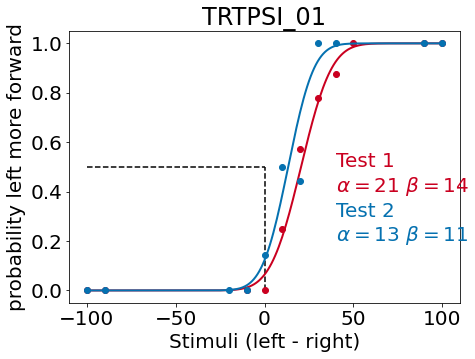

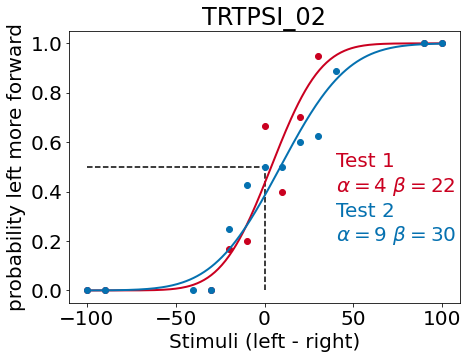

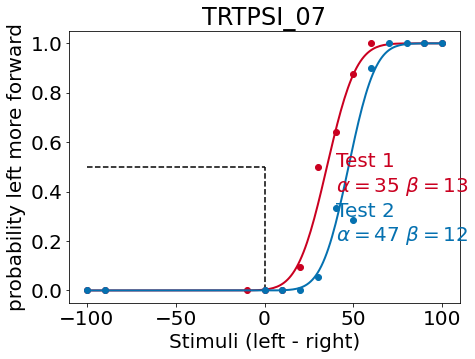

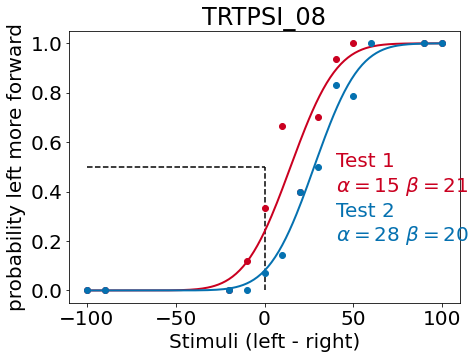

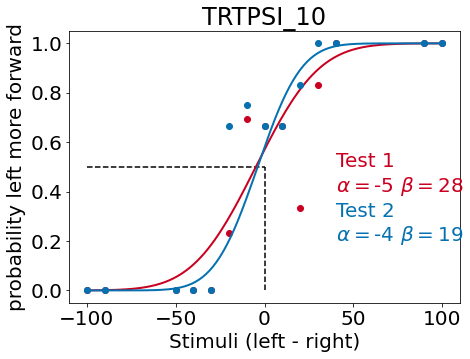

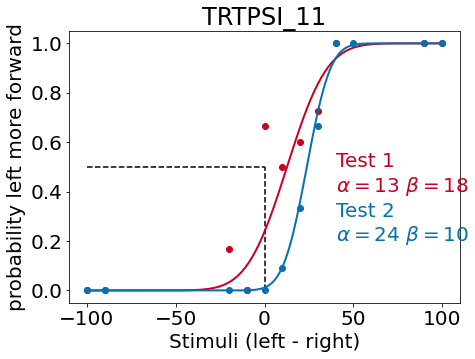

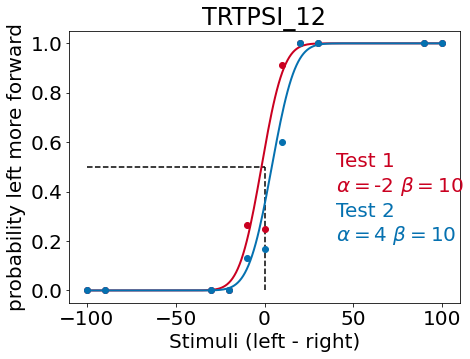

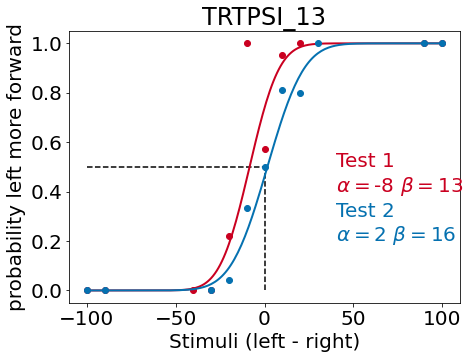

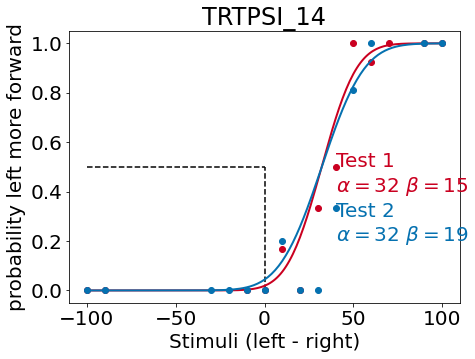

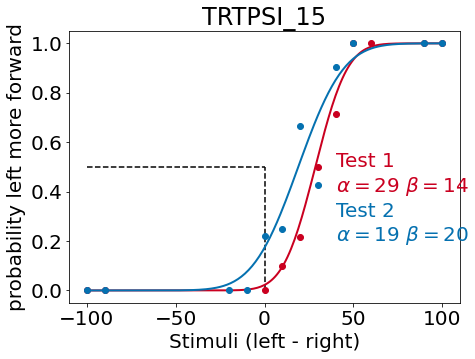

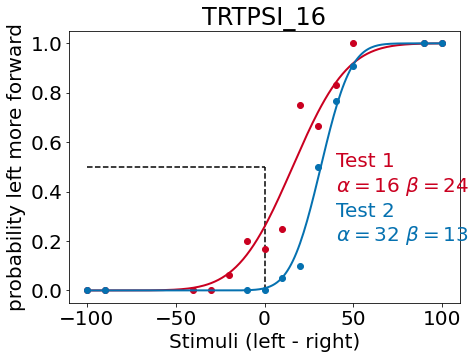

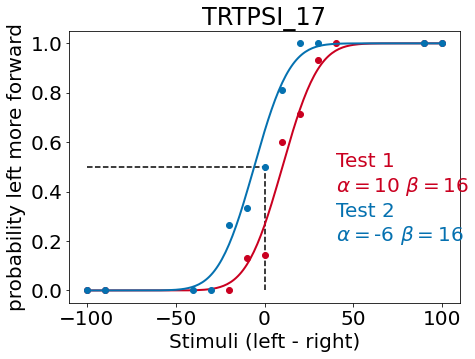

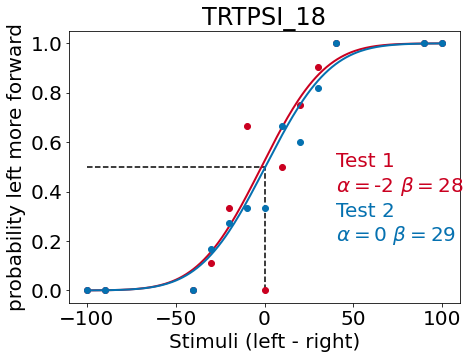

In [7]:
x = np.arange(-100,101)
#Loop through all subejcts
for name, test in grp_subjs:
    
    #Index the different tests
    Test_a = test[test.Test=='a']
    Test_b = test[test.Test=='b']
    
    #Index baseline difference
    BslDiff_1 = round(Test_a.BslDiff.values[0])
    BslDiff_2 = round(Test_b.BslDiff.values[0])

    #Calculate psychometric function for the PSI algorithm
    psi_a = norm.cdf(x,Test_a.Alpha_EV.values[-1]+BslDiff_1,Test_a.Beta_EV.values[-1])
    psi_b = norm.cdf(x,Test_b.Alpha_EV.values[-1]+BslDiff_2,Test_b.Beta_EV.values[-1])
    
    #Index the actual stimulus values
    x_1, Nstims_1, Kleft_1 = UniqueVals(Test_a.AllStims.values+BslDiff_1, Test_a.BinaryResponses.values)
    x_2, Nstims_2, Kleft_2 = UniqueVals(Test_b.AllStims.values+BslDiff_2, Test_b.BinaryResponses.values)

    #Plot
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(np.arange(-100,1),np.ones(101)*0.5,'k--')
    ax.plot(np.zeros(50),np.linspace(0,0.5),'k--')
    
    #Test 1
    ax.plot(x, psi_a, c=color_t1, lw=2)
    ax.plot(x_1, Kleft_1/Nstims_1, 'o', c=color_t1)
    ax.text(40,0.5,'Test 1', c=color_t1)
    ax.text(40, 0.4, r'$\alpha=$' + str(round(Test_a.Alpha_EV.values[-1]+BslDiff_1))
            + r' $\beta=$' + str(round(Test_a.Beta_EV.values[-1])), c=color_t1)
 
    #Test 2
    ax.plot(x, psi_b, c=color_t2, lw=2)
    ax.plot(x_2, Kleft_2/Nstims_2, 'o', c=color_t2)
    ax.text(40,0.3,'Test 2', c=color_t2)
    ax.text(40,0.2, r'$\alpha=$' + str(round(Test_b.Alpha_EV.values[-1]+BslDiff_2))
           + r' $\beta=$' + str(round(Test_b.Beta_EV.values[-1])), c=color_t2)
   
    ax.set(ylabel='probability left more forward', xlabel='Stimuli (left - right)', title=name)
    fig.savefig(fig_path + '/' + name + extension, transparent=True, bbox_inches=None, pad_inches=0.1, edgecolor='w', dpi=1600)
    

## Test 1 and 2 comparison

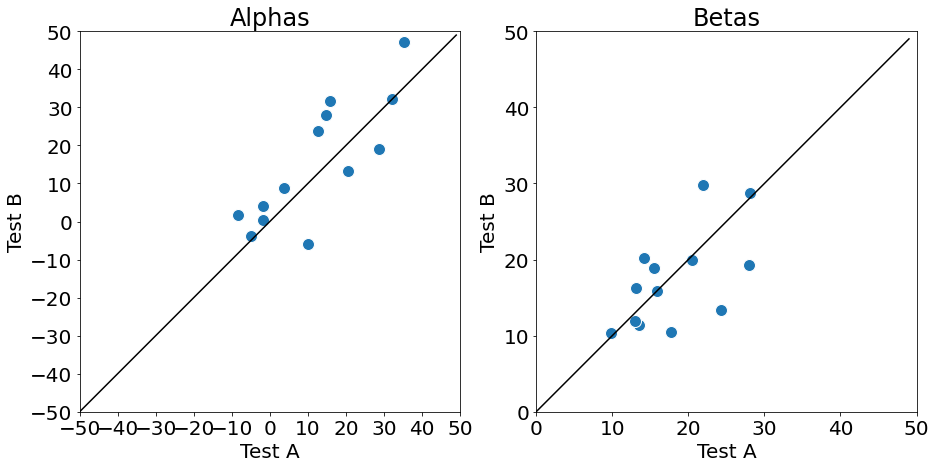

In [17]:
unique_tests = ['a','b']
alphas, betas = np.empty((len(grp_subjs),2)), np.empty((len(grp_subjs),2))
#Extract the final estimates of the alpha and beta values
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    for test_id_idx, test_id in enumerate(unique_tests):
        # print(name, test_id)
        BslDiff = round(test[test.Test==test_id].BslDiff.values[0])
        alphas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Alpha_EV.values[-1]+BslDiff
        betas[subj_name_idx, test_id_idx] = test[test.Test==test_id].Beta_EV.values[-1]
        
#Plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(alphas[:,0], alphas[:,1], 'o', ms=12, mec='w')
ax[0].plot(np.arange(-50,50), np.arange(-50,50),'k')
ax[0].set(xlim=(-50,50), ylim=(-50,50), xticks=np.arange(-50,60,10), yticks=np.arange(-50,60,10), title='Alphas', xlabel='Test A', ylabel='Test B')
ax[1].plot(betas[:,0], betas[:,1],'o', ms=12, mec='w')
ax[1].plot(np.arange(0,50), np.arange(0,50),'k')
ax[1].set(xlim=(0,50), ylim=(0,50), title='Betas', xlabel='Test A', ylabel='Test B')
plt.savefig(fig_path + '/CCCplt' + extension, transparent=False, bbox_inches=None, pad_inches=0.1, edgecolor='w', dpi=1600)

# Stats

## Descriptives

In [9]:
#Alphas
print('All Alphas = ' + str(round(np.mean(alphas))) + '+/-' + str(round(np.std(alphas))))
print('Test A Alphas = ' + str(round(np.mean(alphas[:,0]))) + '+/-' + str(round(np.std(alphas[:,0]))))
print('Test B Alphas = ' + str(round(np.mean(alphas[:,1]))) + '+/-' + str(round(np.std(alphas[:,1]))))

All Alphas = 14+/-15
Test A Alphas = 12+/-14
Test B Alphas = 15+/-16


In [10]:
#Betas
print('All Betas = ' + str(round(np.mean(betas))) + '+/-' + str(round(np.std(betas))))
print('Test A Betas = ' + str(round(np.mean(betas[:,0]))) + '+/-' + str(round(np.std(betas[:,0]))))
print('Test B Betas = ' + str(round(np.mean(betas[:,1]))) + '+/-' + str(round(np.std(betas[:,1]))))

All Betas = 18+/-6
Test A Betas = 18+/-6
Test B Betas = 17+/-6


In [11]:
#Differences
alpha_diff = alphas[:,0] - alphas[:,1]
beta_diff = betas[:,0] - betas[:,1]

print('Mean alpha diff = ' + str(round(np.mean(alpha_diff))) + '+/-' + str(round(np.std(alpha_diff))))
print('Mean beta diff = ' + str(round(np.mean(beta_diff))) + '+/-' + str(round(np.std(beta_diff))))

Mean alpha diff = -3+/-9
Mean beta diff = 1+/-5


In [68]:
alpha_mean = np.mean(alphas,axis=1)
beta_mean = np.mean(betas,axis=1)

## Correlation

$$ Test2 \sim Normal(\mu, \sigma) $$
$$ \mu = \alpha + \beta*Test1 $$
$$ \alpha \sim Normal(0, 20) $$ 
$$ \beta \sim Normal(0,5) $$
$$ \sigma \sim Exp(20) $$

### Alpha


In [288]:
#Calculate the posterior
with pm.Model() as alpha_corr:
    alpha = pm.Normal("alpha", mu=0, sd=20)
    beta = pm.Normal("beta", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 20)
    mu = pm.Deterministic("mu", alpha + beta*alphas[:,0])
    y = pm.Normal("y",mu=mu, sd=sigma, observed=alphas[:,1])
    prior_samples_acorr = pm.sample_prior_predictive()
    trace_alpha_corr = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


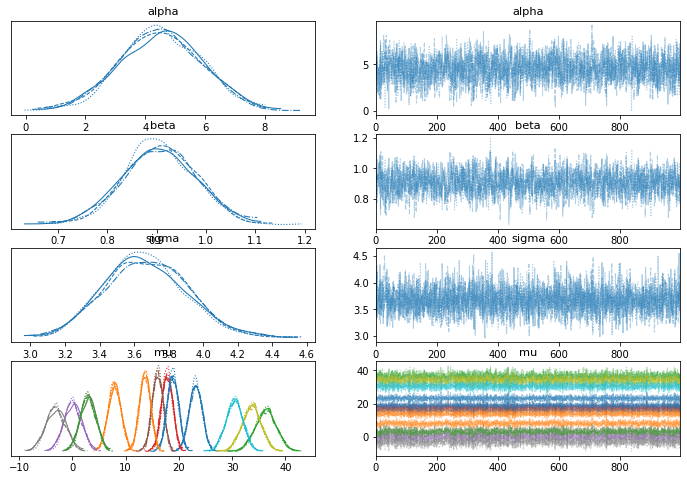

In [289]:
#Check the trace 
az.plot_trace(trace_alpha_corr)
plt.show()

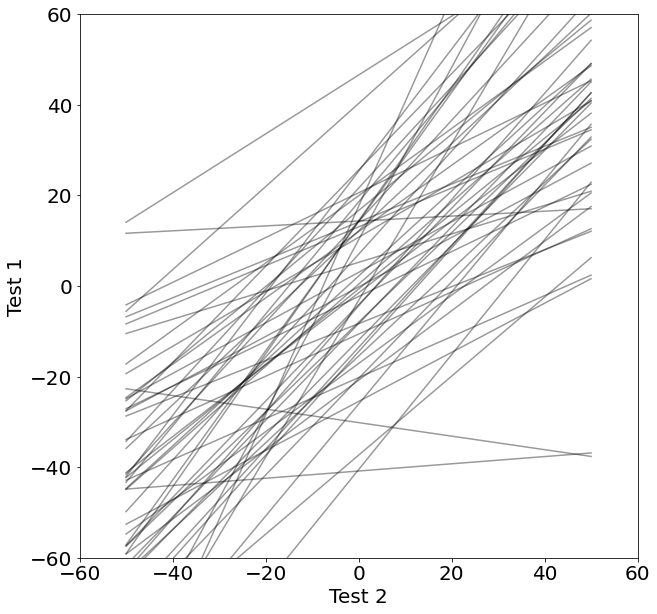

In [238]:
# Make sure the priors are reasonable 
fig, ax = plt.subplots(1, figsize=(10,10))

x = np.linspace(-50, 50, 100)

for a, b in zip(prior_samples_acorr["alpha"][:50], prior_samples_acorr["beta"][:50]):
    y = a + b * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set(ylabel="Test 1", xlabel='Test 2', ylim=(-60, 60), xlim=(-60,60))    
plt.show()

In [239]:
az.summary(trace_alpha_corr, var_names=["alpha", "beta", "sigma"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.241,1.386,1.667,6.913,0.029,0.021,2267.0,2205.0,1.0
beta,0.927,0.074,0.783,1.061,0.002,0.001,2322.0,2446.0,1.0
sigma,3.665,0.240,3.192,4.090,0.005,0.003,2586.0,2313.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


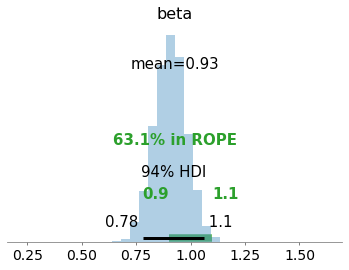

In [240]:
az.plot_posterior(trace_alpha_corr,var_names=["beta"],kind='hist', rope=(0.9, 1.1))
plt.show()

TypeError: Dimension mismatch for x: (71,) and hdi: (4000, 2). Check the dimensions of y andhdi_kwargs to make sure they are compatible

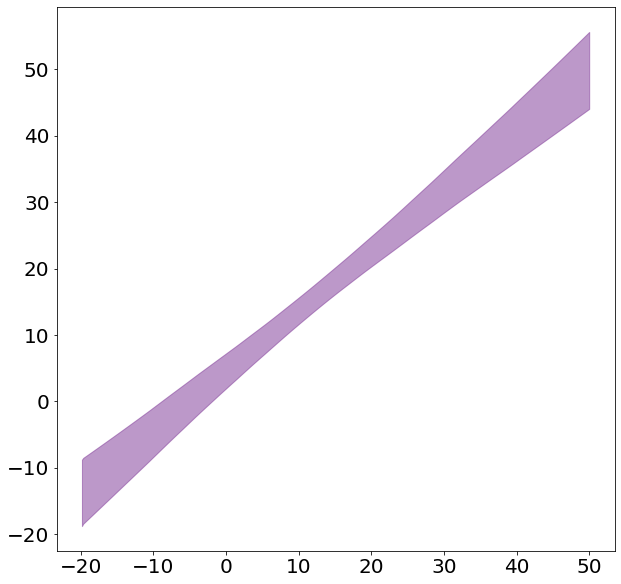

In [334]:
# Nsamps = 100
# post_mu_grp, post_samps = [], []
# for n in range(Nsamps):
#     idx = np.random.randint(len(trace_alpha_corr))

#     post_mu = trace_alpha_corr["alpha"][idx] + trace_alpha_corr["beta"][idx] * alphas[:,0]
#     post_mu_grp.append(post_mu)
    
#     post_sigma = trace_alpha_corr["sigma"][idx]
    
#     post_samps.append(np.random.normal(post_mu, post_sigma))
    
# mean_post_mus = np.mean(post_mu_grp,axis=0)

with alpha_corr:
    T2_pred = pm.sample_posterior_predictive(trace_alpha_corr)
    
x_vals_aT1 = np.arange(-20, 51)
mu_pred = np.zeros((len(x_vals_aT1), 4000))
post_samps = []
for i, x in enumerate(x_vals_aT1):
    mu_pred[i] = trace_alpha_corr["alpha"] + trace_alpha_corr["beta"]*x
    post_samps.append(np.random.normal(mu_pred[i], trace_alpha_corr["sigma"]))



# height_pred_hdi = az.hdi(trace_alpha_corr.posterior_predictive["height"], hdi_prob=0.89)

fig, ax = plt.subplots(figsize=(10,10))
az.plot_hdi(x_vals_aT1, mu_pred.T, color=color_a, hdi_prob=0.95)
az.plot_hdi(x_vals_aT1, post_samps, color=color_a, hdi_prob=0.95)
ax.plot(x_vals_aT1, np.mean(mu_pred, axis=1), c=color_a, lw=3)
ax.plot(alphas[:,0],alphas[:,1], 'o', c=color_a, ms=10)
ax.plot(np.arange(-40,51),np.arange(-40,51),'k--')
plt.show()

# az.plot_hdi(alphas[:,0], post_samps)
# ax.plot(alphas[:,0], mean_post_mus)
# ax.set(ylim=(-50,50),xlim=(-50,50), ylabel='Test 2', xlabel='Test 1', title='Alpha posterior samples')
# plt.show()

### Beta

In [243]:
#Calculate the posterior
with pm.Model() as beta_corr:
    alpha = pm.Normal("alpha", mu=10, sd=20)
    beta = pm.Normal("beta", mu=0, sd=20)
    sigma = pm.Exponential("sigma", 20)
    mu = pm.Deterministic("mu", alpha + beta*betas[:,0])
    y = pm.Normal("y",mu=mu, sd=sigma, observed=betas[:,1])
    trace_beta_corr = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


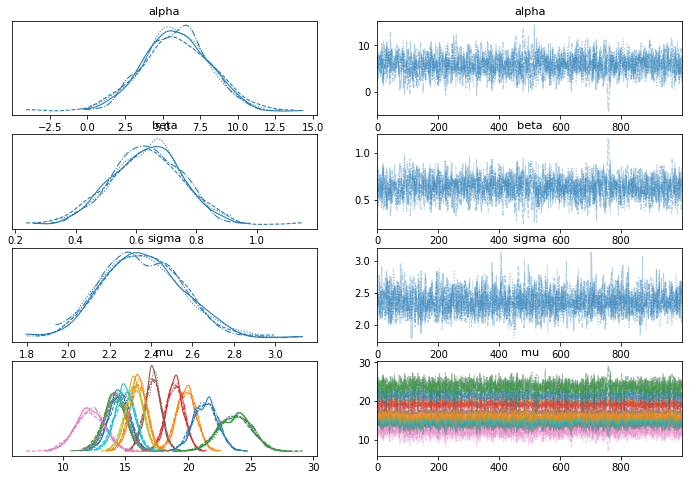

In [244]:
#Check the trace 
az.plot_trace(trace_beta_corr)
plt.show()

In [245]:
az.summary(trace_beta_corr, var_names=["alpha", "beta", "sigma"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.891,2.207,1.601,9.837,0.058,0.041,1486.0,1626.0,1.0
beta,0.636,0.116,0.431,0.867,0.003,0.002,1512.0,1690.0,1.0
sigma,2.359,0.191,2.008,2.703,0.004,0.003,1988.0,1592.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


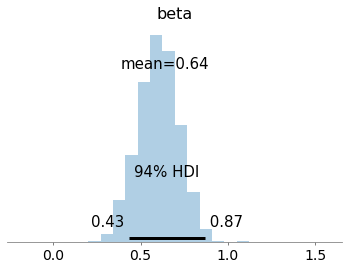

In [246]:
az.plot_posterior(trace_beta_corr,var_names=["beta"],kind='hist')
plt.show()

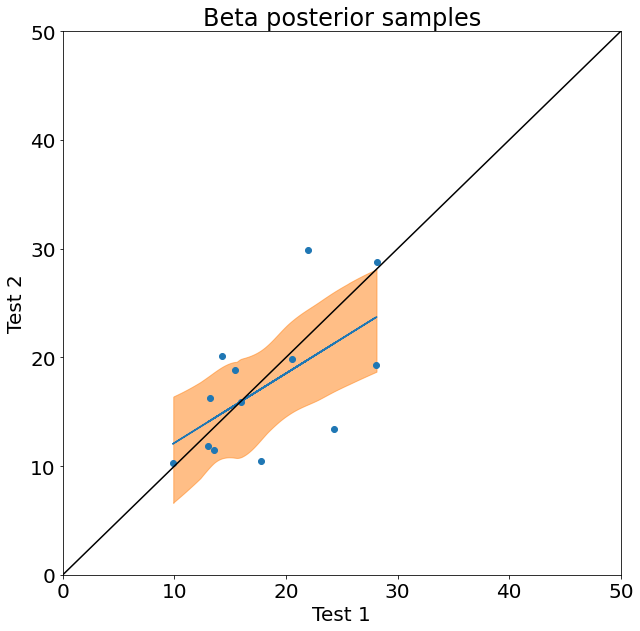

In [271]:
Nsamps = 100
post_mu_grp_betas, post_samps_betas = [], []
for n in range(Nsamps):
    idx = np.random.randint(len(trace_beta_corr))
    
    post_mu_betas = trace_beta_corr["alpha"][idx] + trace_beta_corr["beta"][idx] * betas[:,0]
    post_mu_grp_betas.append(post_mu_betas)
    
    post_sigma_betas = trace_beta_corr["sigma"][idx]
    
    post_samps_betas.append(np.random.normal(post_mu_betas, post_sigma_betas))

mean_post_mus_betas = np.mean(post_mu_grp_betas,axis=0)    

fig, ax = plt.subplots(figsize=(10,10))
az.plot_hdi(betas[:,0], post_samps_betas)
ax.plot(betas[:,0], mean_post_mus_betas)
ax.scatter(betas[:,0],betas[:,1])
ax.plot(np.arange(0,51),np.arange(0,51),'k-')
ax.set(ylim=(0,50),xlim=(0,50), ylabel='Test 2', xlabel='Test 1', title='Beta posterior samples')
plt.show()

## Bland-altman agreement 

### Test for a bias (mean difference from 0)

$$ TestDifference \sim Normal(\mu, \sigma) $$
$$ \mu \sim Normal(0,20) $$
$$ \sigma \sim Exp(20) $$

#### Alpha

In [53]:
#Calculate the posterior
with pm.Model() as alpha_bias_M:
    mu = pm.Normal("mu", mu=0, sd=20)
    sigma = pm.Exponential("sigma", 20)
    y = pm.Normal("y",mu=mu, sd=sigma, observed=alpha_diff)
    trace_alpha_bias = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


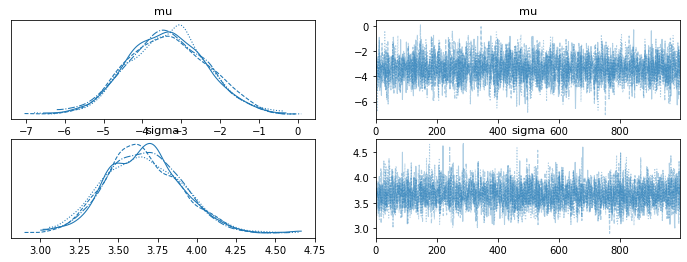

In [55]:
az.plot_trace(trace_alpha_bias)
plt.show()

In [56]:
az.summary(trace_alpha_bias, var_names=["mu", "sigma"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-3.364,1.014,-5.170,-1.429,0.017,0.012,3730.0,2815.0,1.0
sigma,3.661,0.240,3.241,4.133,0.004,0.003,3472.0,2747.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


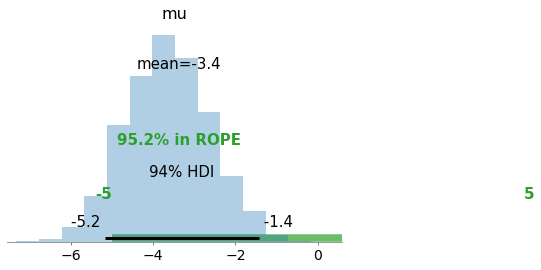

In [60]:
az.plot_posterior(trace_alpha_bias,var_names=["mu"],kind='hist', rope=(-5,5))
plt.show()

#### Beta

In [61]:
#Calculate the posterior
with pm.Model() as beta_bias_M:
    mu = pm.Normal("mu", mu=0, sd=20)
    sigma = pm.Exponential("sigma", 20)
    y = pm.Normal("y",mu=mu, sd=sigma, observed=beta_diff)
    trace_beta_bias = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


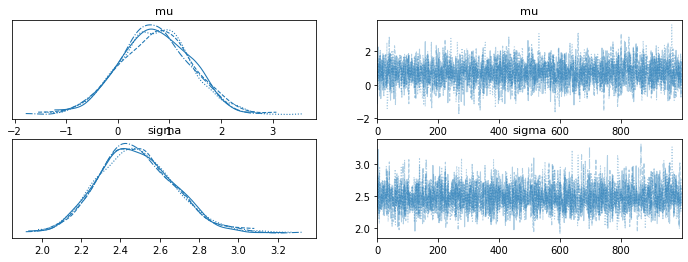

In [62]:
az.plot_trace(trace_beta_bias)
plt.show()

In [113]:
az.summary(trace_beta_bias, var_names=["mu", "sigma"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.724,0.693,-0.501,2.070,0.012,0.009,3453.0,2462.0,1.0
sigma,2.483,0.193,2.107,2.821,0.003,0.002,3664.0,3112.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


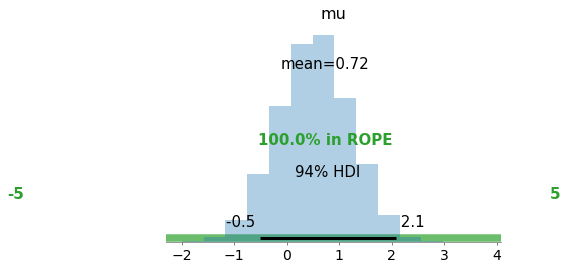

In [64]:
az.plot_posterior(trace_beta_bias,var_names=["mu"],kind='hist', rope=(-5,5))
plt.show()

### Limits of agreement

Model:

$$ \theta_{hi} \sim Normal(\mu_{hi}, \sigma_{hi}) $$

$$ \mu_{hi} = \mu_0 + 1.96*\sigma_0 $$

#### Alpha


In [ ]:
#Calculate the posterior
with pm.Model() as alpha_LOA_M:
    mu0 = pm.Normal("mu0", mu=1, sd=0.5)
    sigma0 = pm.Exponential("sigma0", 20)
    sigma_hi = pm.Exponential("sigma_hi", 20)
    mu_hi = pm.Deterministic("mu_hi", mu_0 + 1.96*sigma0)
    theta_hi = pm.Normal("theta_hi",mu=mu_hi, sd=sigma_hi, observed=alphas[:,1])
    trace_alpha_LOA = pm.sample(1000, tune=1000)

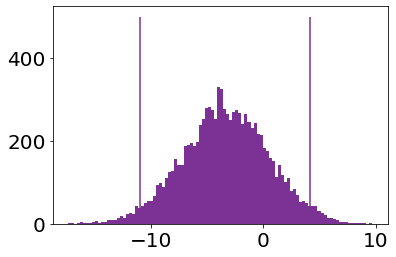

[-10.961500342473194, 4.166745969192826]


In [342]:
Nsamps = 10000
post_samps_alpha = []
for n in range(Nsamps):
    idx = np.random.randint(len(trace_alpha_bias))
    
    post_mu_alpha = trace_alpha_bias['mu'][idx]
    post_sigma_alpha = trace_alpha_bias['sigma'][idx]
    
    post_samps_alpha.append(np.random.normal(post_mu_alpha, post_sigma_alpha))

sorted_samps_alpha = np.sort(post_samps)

hi95_idx = int(Nsamps*0.975)
lo95_idx = int(Nsamps*0.025)

alpha_LOA = [sorted_samps_alpha[lo95_idx], sorted_samps_alpha[hi95_idx]]
             
plt.hist(sorted_samps_alpha, bins=100, color=color_a)
plt.vlines(alpha_LOA, ymin=0, ymax=500, color=color_a)
plt.show()
print([sorted_samps[lo95_idx], sorted_samps[hi95_idx]])

#### Beta

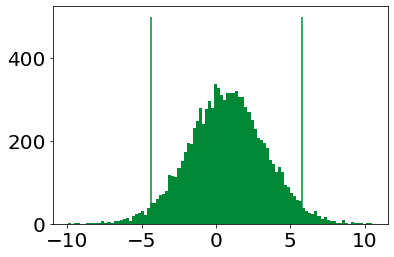

[-4.363798608875266, 5.7837734509802505]


In [344]:
Nsamps = 10000
post_samps_beta = []
for n in range(Nsamps):
    idx = np.random.randint(len(trace_beta_bias))
    
    post_mu_beta = trace_beta_bias['mu'][idx]
    post_sigma_beta = trace_beta_bias['sigma'][idx]
    
    post_samps_beta.append(np.random.normal(post_mu_beta, post_sigma_beta))

sorted_samps_beta = np.sort(post_samps_beta)

hi95_idx = int(Nsamps*0.975)
lo95_idx = int(Nsamps*0.025)

beta_LOA = [sorted_samps_beta[lo95_idx], sorted_samps_beta[hi95_idx]]
             
plt.hist(post_samps_beta, bins=100, color=color_b)
plt.vlines(beta_LOA, ymin=0, ymax=500, color=color_b)
plt.show()
print([sorted_samps_beta[lo95_idx], sorted_samps_beta[hi95_idx]])

### Regression of 'true' values and difference values

#### Alpha

$$ TestDifference \sim Normal(\mu, \sigma) $$
$$ \mu = \alpha + \beta*TestMean $$
$$ \alpha \sim Normal(0, 20) $$ 
$$ \beta \sim Normal(0,10) $$
$$ \sigma \sim Exp(20) $$

In [250]:
#Calculate the posterior
with pm.Model() as alpha_diff_corr:
    alpha = pm.Normal("alpha", mu=0, sd=20)
    beta = pm.Normal("beta", mu=0, sd=10)
    sigma = pm.Exponential("sigma", 20)
    mu = pm.Deterministic("mu", alpha + beta*alpha_mean)
    y = pm.Normal("y",mu=mu, sd=sigma, observed=alpha_diff)
    trace_alpha_diff_corr = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jonathanwood/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


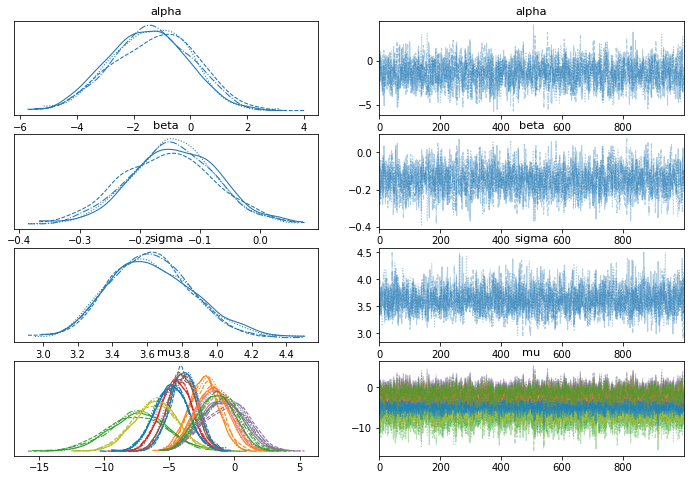

In [251]:
#Check the trace 
az.plot_trace(trace_alpha_diff_corr)
plt.show()

In [252]:
az.summary(trace_alpha_diff_corr, var_names=["alpha", "beta", "sigma"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.371,1.412,-4.035,1.142,0.032,0.023,1917.0,2546.0,1.0
beta,-0.147,0.073,-0.282,-0.004,0.002,0.001,1856.0,2415.0,1.0
sigma,3.623,0.240,3.175,4.062,0.004,0.003,2892.0,2561.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


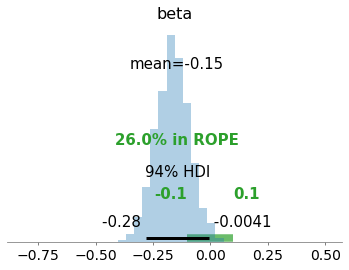

Got error No model on context stack. trying to find log_likelihood in translation.


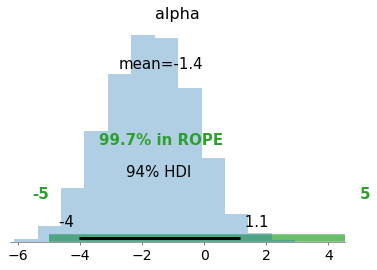

In [253]:
az.plot_posterior(trace_alpha_diff_corr,var_names=["beta"],kind='hist', rope=(-0.1, 0.1))
plt.show()
az.plot_posterior(trace_alpha_diff_corr,var_names=["alpha"],kind='hist', rope=(-5, 5))
plt.show()

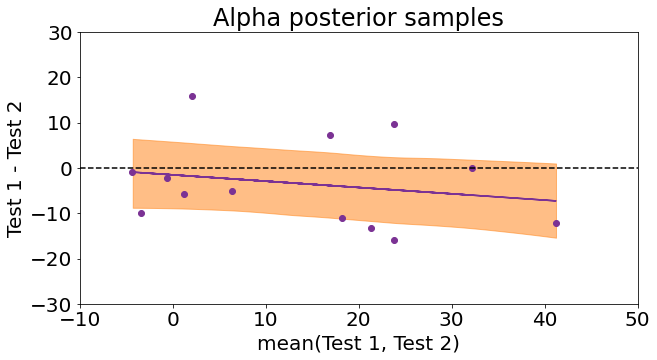

In [254]:
Nsamps = 10000
post_mu_grp_adiff, post_samps_adiff = [], []
for n in range(Nsamps):
    
    idx = np.random.randint(len(trace_alpha_diff_corr))
    
    post_mu_adiff = trace_alpha_diff_corr["alpha"][idx] + trace_alpha_diff_corr["beta"][idx] * alpha_mean
    post_mu_grp_adiff.append(post_mu_adiff)
    
    post_sigma_adiff = trace_alpha_diff_corr["sigma"][idx]
    
    post_samps_adiff.append(np.random.normal(post_mu_adiff, post_sigma_adiff))
    
mean_post_mus_adiff = np.mean(post_mu_grp_adiff,axis=0)    

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alpha_mean,alpha_diff,'o', c=color_a)
ax.plot(np.arange(-10,51), np.zeros(61),'k--')
az.plot_hdi(alpha_mean, post_samps_adiff)
ax.plot(alpha_mean, mean_post_mus_adiff, c=color_a)
ax.set(ylim=(-30,30),xlim=(-10,50), ylabel='Test 1 - Test 2', xlabel='mean(Test 1, Test 2)', title='Alpha posterior samples')
plt.show()

#### Beta

In [89]:
#Calculate the posterior
with pm.Model() as beta_diff_corr:
    alpha = pm.Normal("alpha", mu=0, sd=20)
    beta = pm.Normal("beta", mu=0, sd=10)
    sigma = pm.Exponential("sigma", 20)
    mu = alpha + beta*beta_mean
    y = pm.Normal("y",mu=mu, sd=sigma, observed=beta_diff)
    trace_beta_diff_corr = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.6927994502874293, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6962634710177997, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


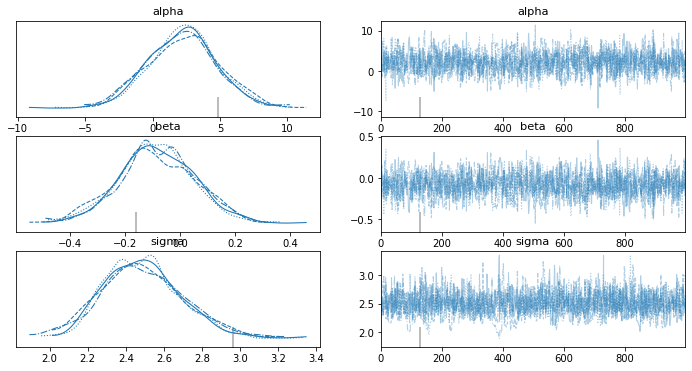

In [90]:
#Check the trace 
az.plot_trace(trace_beta_diff_corr)
plt.show()

In [91]:
az.summary(trace_beta_diff_corr, var_names=["alpha", "beta", "sigma"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.246,2.544,-2.583,6.912,0.076,0.057,1122.0,1255.0,1.00
beta,-0.085,0.136,-0.356,0.161,0.004,0.003,1141.0,1267.0,1.00
sigma,2.489,0.208,2.123,2.880,0.007,0.005,811.0,326.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.


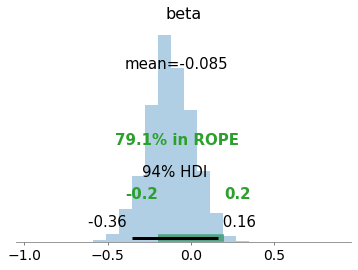

In [93]:
az.plot_posterior(trace_beta_diff_corr,var_names=["beta"],kind='hist', rope=(-0.2, 0.2))
plt.show()

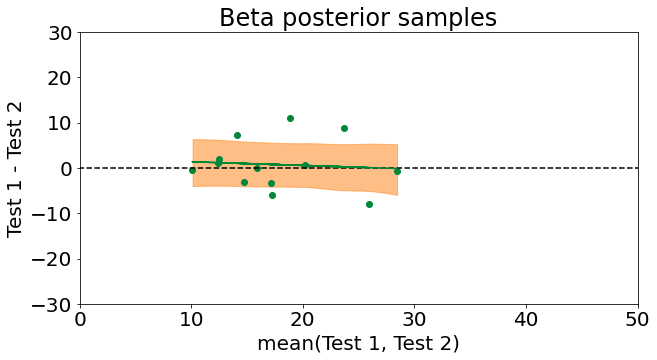

In [195]:
Nsamps = 10000
post_mu_grp_bdiff, post_samps_bdiff = [], []
for n in range(Nsamps):
    
    idx = np.random.randint(len(trace_beta_diff_corr))
    
    post_mu_bdiff = trace_beta_diff_corr["alpha"][idx] + trace_beta_diff_corr["beta"][idx] * beta_mean
    post_mu_grp_bdiff.append(post_mu_bdiff)
    
    post_sigma_bdiff = trace_beta_diff_corr["sigma"][idx]
    
    post_samps_bdiff.append(np.random.normal(post_mu_bdiff, post_sigma_bdiff))
    
mean_post_mus_bdiff = np.mean(post_mu_grp_bdiff,axis=0)    

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(beta_mean,beta_diff,'o', c=color_b)
ax.plot(np.arange(-10,51), np.zeros(61),'k--')
az.plot_hdi(beta_mean, post_samps_bdiff)
ax.plot(beta_mean, mean_post_mus_bdiff, c=color_b)
ax.set(ylim=(-30,30),xlim=(0,50), ylabel='Test 1 - Test 2', xlabel='mean(Test 1, Test 2)', title='Beta posterior samples')
plt.show()

### Final Bland altman plotpost_LOA_alpha_up

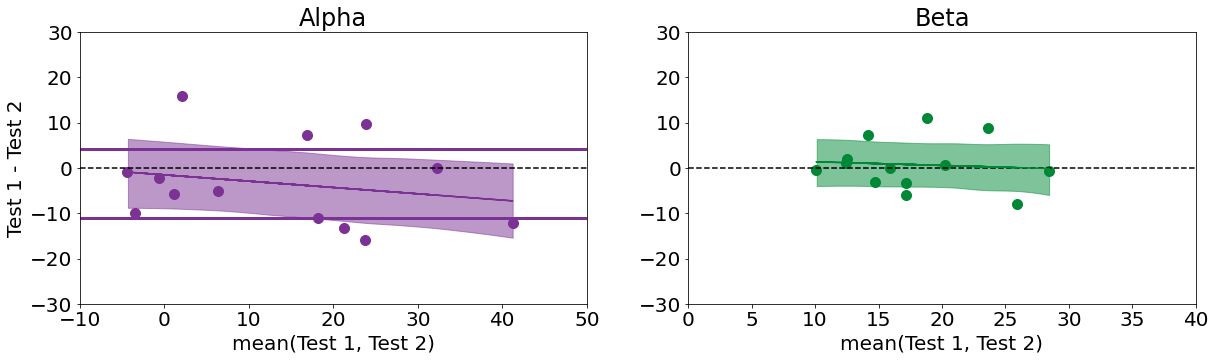

In [348]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
x_a = np.arange(-10,51)

ax[0].plot(alpha_mean,alpha_diff,'o', c=color_a, ms=10)
ax[0].plot(x_a, np.zeros(len(x_a)),'k--')
az.plot_hdi(alpha_mean, post_samps_adiff, ax=ax[0], color=color_a)
ax[0].plot(alpha_mean, mean_post_mus_adiff, c=color_a)
ax[0].hlines(alpha_LOA, xmin=-10, xmax=50, color=color_a, lw=3)
ax[0].set(ylim=(-30,30),xlim=(-10,50), ylabel='Test 1 - Test 2', xlabel='mean(Test 1, Test 2)', title='Alpha')

ax[1].plot(beta_mean,beta_diff,'o', c=color_b, ms=10)
ax[1].plot(np.arange(-10,51), np.zeros(61),'k--')
az.plot_hdi(beta_mean, post_samps_bdiff, ax=ax[1], color=color_b)
ax[1].plot(beta_mean, mean_post_mus_bdiff, c=color_b)
ax[1].set(ylim=(-30,30),xlim=(0,40), xlabel='mean(Test 1, Test 2)', title='Beta')
plt.show()

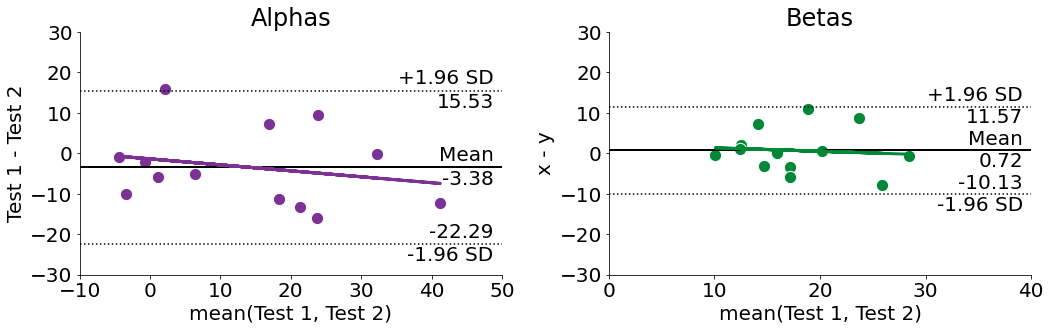

In [105]:
#Bland-altman
fig, ax = plt.subplots(1,2, figsize=(15,5), tight_layout=True) 
pg.plot_blandaltman(alphas[:,0], alphas[:,1],ax=ax[0],confidence=None, scatter_kws={'color':color_a, 'edgecolors':'w', 's':150})
ax[0].plot(mean_a, diff_hat_a, c=color_a, lw=3)
ax[0].set(title='Alphas', xlabel='mean(Test 1, Test 2)', ylabel='Test 1 - Test 2',ylim=(-30,30),xlim=(-10,50))

pg.plot_blandaltman(betas[:,0], betas[:,1],ax=ax[1],confidence=None, scatter_kws={'color':color_b, 'edgecolors':'w', 's':150})
ax[1].plot(mean_b, diff_hat_b, c=color_b, lw=3)
ax[1].set(xlabel='mean(Test 1, Test 2)', title='Betas', ylim=(-30,30),xlim=(0,40))
plt.show()

In [ ]:
np.mean(alpha_diff) - 1.96*np.std(alpha_diff, ddof=1)

-22.292278060925156

## Validity - logistic regression

In [176]:
#Orgainze the data
x_stims, y, x_move_dir = np.empty((len(DF),1)), np.empty((len(DF),1)), np.empty((len(DF),1))
for i in range(len(DF)):
    x_stims[i,0] = DF.AllStims.values[i] + round(DF.BslDiff.values[i])
    x_move_dir[i,0] = DF.AllStarts.values[i] > DF.AllStims.values[i]
    
x_SID = [np.ones((150,1), dtype=int)*int(i) for i in range(len(np.unique(DF.SID)))]
x_SID = np.concatenate(x_SID)
y = DF.BinaryResponses.values


In [169]:
X = np.concatenate((x_SID,x_stims,x_move_dir),axis=1)

In [179]:
pg.logistic_regression(X,y)

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-1.036594,0.134702,-7.695476,1.409689e-14,-1.300604,-0.772583
1,x1,0.000054,0.015831,0.003400,9.972873e-01,-0.030974,0.031082
2,x2,0.063883,0.002976,21.466867,3.177274e-102,0.058050,0.069715
3,x3,0.164130,0.118763,1.381989,1.669752e-01,-0.068642,0.396901
